# Temperature Profile Classification - 2 Class system
GMM classification of Southern Ocean Argo float temperature profile data. This notebook looks at automatic generation for PCA N values, with 2 classes.<br><br>
### Dask import

<br>

### Choices for data

In [ ]:
#File imports
maskName = "OceanMaskESM2"
dataFileName = "GMMSampleData3AL.npy"
sampleFileName = "GMMSampleTimeGeo3.npy"
scalerName = "GMMScaler3AL.bin"
modelName = "GMM3ALMClass"

#Data definitions
lastESMDecade = slice('2005-01','2014-12')

#Custom GMM variables
pcaThreshold = 0.98
pcaNControl = 4 #set to int value to select, otherwise pcaThreshold is used to automatically assign value
firstBicLoopControl = 10 #number of times bic value is calculated for each number of classes
cvType = "full"

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [3]:
sampleDataLabelled = np.load(dataFileName)
sampleDepthAxis = sampleDataLabelled[0]
sampleData = sampleDataLabelled[1:]

sampleTimeGeo = np.load(sampleFileName, allow_pickle=True)
print("Sample data loaded into sampleData.\nSample time geo data loaded into sampleTimeGeo.")

Sample data loaded into sampleData.
Sample time geo data loaded into sampleTimeGeo.


<br>
<b>Loading ocean Mask</b>

In [4]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded and stored in oceanMask")

Mask Loaded and stored in oceanMask


<br>
<b>Combining sample data and sample time/geo data</b>

In [5]:
metaData = {"Lat":sampleTimeGeo[0], "Lon":sampleTimeGeo[1], "Time":sampleTimeGeo[2]}
sampleMetaDF = pd.DataFrame(metaData, columns=["Lat", "Lon", "Time"])
sampleDataDF = pd.DataFrame(sampleData, columns=sampleDepthAxis)
sampleDF = pd.concat([sampleMetaDF,sampleDataDF], axis=1)
sampleDF["Time"] = pd.to_datetime(sampleDF["Time"])
print("SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.")

SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
<li>loadModel - loadeds and returns GMM model named in input.
</ul>

In [6]:
def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> bicPlot - Plots BIC score array against component number.
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDF - plots location and classification of data points for an input data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
<li> tempPointPlot - Plots the temperature profile of a single point against depth.
<li> tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [7]:
def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    bicArrayMin = np.min(bicArray)
    bicRange = bicArrayMax-bicArrayMin
    if bicRange == 0:
        bicRange = 20 #provides border 1 if all bic values are identical
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([bicArrayMin-0.05*bicRange, bicArrayMax+0.05*bicRange])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)
    
    
def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")
    

def locationPlotGroupDF(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["Lon"], dataFrame["Lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["Time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["Lon"], timeData["Lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")
    
    
def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
    
def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["Lon"], dataFrame["Lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["Time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["Lon"], timeData["Lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")
    
    
def tempPointPlot(dataArray, label, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))
    plt.gca().invert_yaxis()

    
def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0])[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)'''

print("Plotting functions defined.")

Plotting functions defined.


<br>

### Scaling
<b>Scaling Implementation</b><br>
Applying scaling to the data set, ensuring all levels have same influence over data.

In [8]:
scalerLoad = load(scalerName)
sampleDataScaled = scalerLoad.transform(sampleData)
print("Scaling of sampleData complete, stored in sampleDataScaled.")

Scaling of sampleData complete, stored in sampleDataScaled.


/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<br>
<b>Scaling comparison</b><br>
Comparing raw temperature profiles with their scaled equivalent. To show individual plots set solo to True.

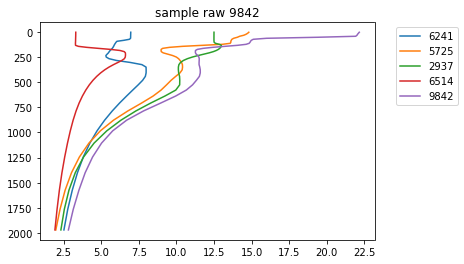

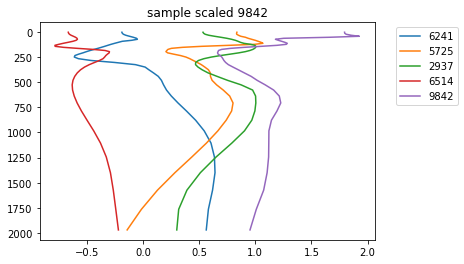

In [9]:
solo = False #Set to true for seperate plots, false for combined plots.
for i in range(5):
    x = np.random.randint(10000)
    tempPointPlot(sampleData[x], x, "sample raw "+str(x), solo*2*i)
    tempPointPlot(sampleDataScaled[x], x, "sample scaled "+str(x), solo*2*i+1)

<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [10]:
pca = PCA(n_components=pcaNControl) #initialising PCA 
pca.fit(sampleDataScaled) #fitting model to data
sampleDataScaledPCA = pca.transform(sampleDataScaled) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### Model Import
The GMM calculated in the v1.3 notebook is here imported.

In [11]:
bestGMModel = loadModel(modelName)
bicMin = bestGMModel.bic(sampleDataScaledPCA)
bicComponentMin = bestGMModel.n_components
componentNo = bicComponentMin
print("Model "+modelName+" loaded. The bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+".")

Model GMM3ALMClass loaded. The bicScore was 128578.74 for 21.


<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [12]:
labels = bestGMModel.predict(sampleDataScaledPCA) #assignment of class labels from best GMM

posteriorProbs = bestGMModel.predict_proba(sampleDataScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)

indexArray = np.empty(shape=0, dtype=int)
maxProbsArray = np.empty(shape=0)
uncertaintyArray = np.empty(shape=0)

for i in range(len(posteriorProbs)):
    sortedProbs = np.sort(posteriorProbs[i])
    maxProbsPart = sortedProbs[-1]
    max2ProbsPart = sortedProbs[-2]
    maxProbsArray = np.append(maxProbsArray, maxProbsPart)
    uncertaintyPart = 1 - (maxProbsPart - max2ProbsPart)
    uncertaintyArray = np.append(uncertaintyArray, uncertaintyPart)
    maxIndex = np.where(posteriorProbs[i] == maxProbsPart)
    max2Index = np.where(posteriorProbs[i] == max2ProbsPart)
    indexArray = np.append(indexArray, int(max2Index[0]))

try:
    sampleDF = sampleDF.drop(columns=["label", "label2", "max posterior prob", "classUncertainty"]) #removes any previous labels or probabilities
except:
    pass
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "label2", indexArray, True)
sampleDF.insert(5, "max posterior prob", maxProbsArray, True)
sampleDF.insert(6, "classUncertainty", uncertaintyArray, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

Labels identified for model (21 components) and added to sampleDF with associated probability.


<br>

### Calculating properties of profiles based on class assignment

In [13]:
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).


<br>

### Sort the labels based on mean near-surface temperatures

In [14]:
surfaceMeans = sampleDFMeans[sampleDepthAxis[0]].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, componentNo)))

try:
    sampleDF = sampleDF.drop(columns =["labelSorted", "label2Sorted"])
    print("dropped")
except:
    pass
sampleDF.insert(6, "labelSorted", sampleDF["label"].map(di))
sampleDF.insert(7, "label2Sorted", sampleDF["label2"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.


<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [15]:
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print("Number of samples in each group calculated and stored in profileCount.")

sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).
Number of samples in each group calculated and stored in profileCount.


<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [16]:
print(sampleDFSortMeans[sampleDataDF.columns[0]])

labelSorted
0     -1.614215
1     -1.097070
2      0.326235
3      0.421499
4      2.069190
5      2.732313
6      4.502740
7      5.858420
8      8.484899
9      9.054304
10     9.510666
11    11.807244
12    13.160087
13    13.216997
14    14.028844
15    16.834449
16    18.081703
17    18.437080
18    18.984593
19    19.298035
20    19.820597
Name: 5.0, dtype: float64


In [22]:
sampleDF

Lat    Lon       Time  label  label2  max posterior prob  labelSorted  \
0     -44.5    1.5 2005-01-01      2       0            0.998105            9   
1     -48.5  106.5 2005-01-01      6      17            0.432098           10   
2     -57.5  109.5 2005-01-01     20      10            0.980133            5   
3     -46.5  305.5 2005-01-01      6      10            0.994686           10   
4     -35.5  179.5 2005-01-01     16       0            0.997473           17   
...     ...    ...        ...    ...     ...                 ...          ...   
11995 -60.5  169.5 2014-12-01      1      17            0.465353            4   
11996 -61.5  190.5 2014-12-01      8       1            0.989254            3   
11997 -39.5  235.5 2014-12-01     16      18            0.806276           17   
11998 -33.5  105.5 2014-12-01     16       5            0.765561           17   
11999 -70.5  266.5 2014-12-01      8      14            0.402339            3   

       label2Sorted  classUncertainty        5.0  ...  707.56328125  787.0025  \
0                19          0.003129  10.687749  ...      6.807866  6.171303   
1                 7          0.990854   7.738212  ...      5.179966  4.666594   
2                 6          0.039325   5.078968  ...      2.480474  2.220554   
3                 6          0.010555  14.225867  ...      5.753474  5.210637   
4                19          0.004276  20.983622  ...      9.000098  7.771926   
...             ...               ...        ...  ...           ...       ...   
11995             7          0.933594   4.536870  ...      3.857132  3.612632   
11996             4          0.017491   2.454878  ...      1.986679  1.936783   
11997            18          0.293476  16.610630  ...      8.376254  7.388602   
11998            15          0.385777  17.625355  ...      8.496078  7.611646   
11999             2          0.919039  -1.634699  ...      1.647125  1.513076   

       878.825234375  984.705859375  1106.20421875  1244.566953125  \
0           5.597465       5.114653       4.694770        4.297262   
1           4.210050       3.814740       3.477808        3.183227   
2           2.003741       1.828311       1.687342        1.572861   
3           4.672422       4.207401       3.770320        3.372576   
4           6.510622       5.334233       4.379849        3.687455   
...              ...            ...            ...             ...   
11995       3.383234       3.164223       2.949798        2.739614   
11996       1.916345       1.904690       1.879622        1.835907   
11997       6.347534       5.372767       4.532490        3.855061   
11998       6.619615       5.656841       4.792989        4.015299   
11999       1.435534       1.410604       1.405051        1.405336   

       1400.4971875  1573.94640625  1764.00328125  1968.9442187500001  
0          3.917223       3.540847       3.159339            2.794699  
1          2.909309       2.645681       2.410023            2.199185  
2          1.480341       1.405463       1.340440            1.278650  
3          3.063626       2.825029       2.608482            2.364247  
4          3.210775       2.863639       2.534800            2.242495  
...             ...            ...            ...                 ...  
11995      2.539490       2.353583       2.178612            2.004222  
11996      1.746782       1.645420       1.545697            1.451967  
11997      3.339511       2.958091       2.674946            2.456027  
11998      3.309495       2.735736       2.331190            2.045532  
11999      1.408503       1.410765       1.408005            1.370209  

[12000 rows x 55 columns]

<br>

### Plotting the means and standard deviations of the classes by profile

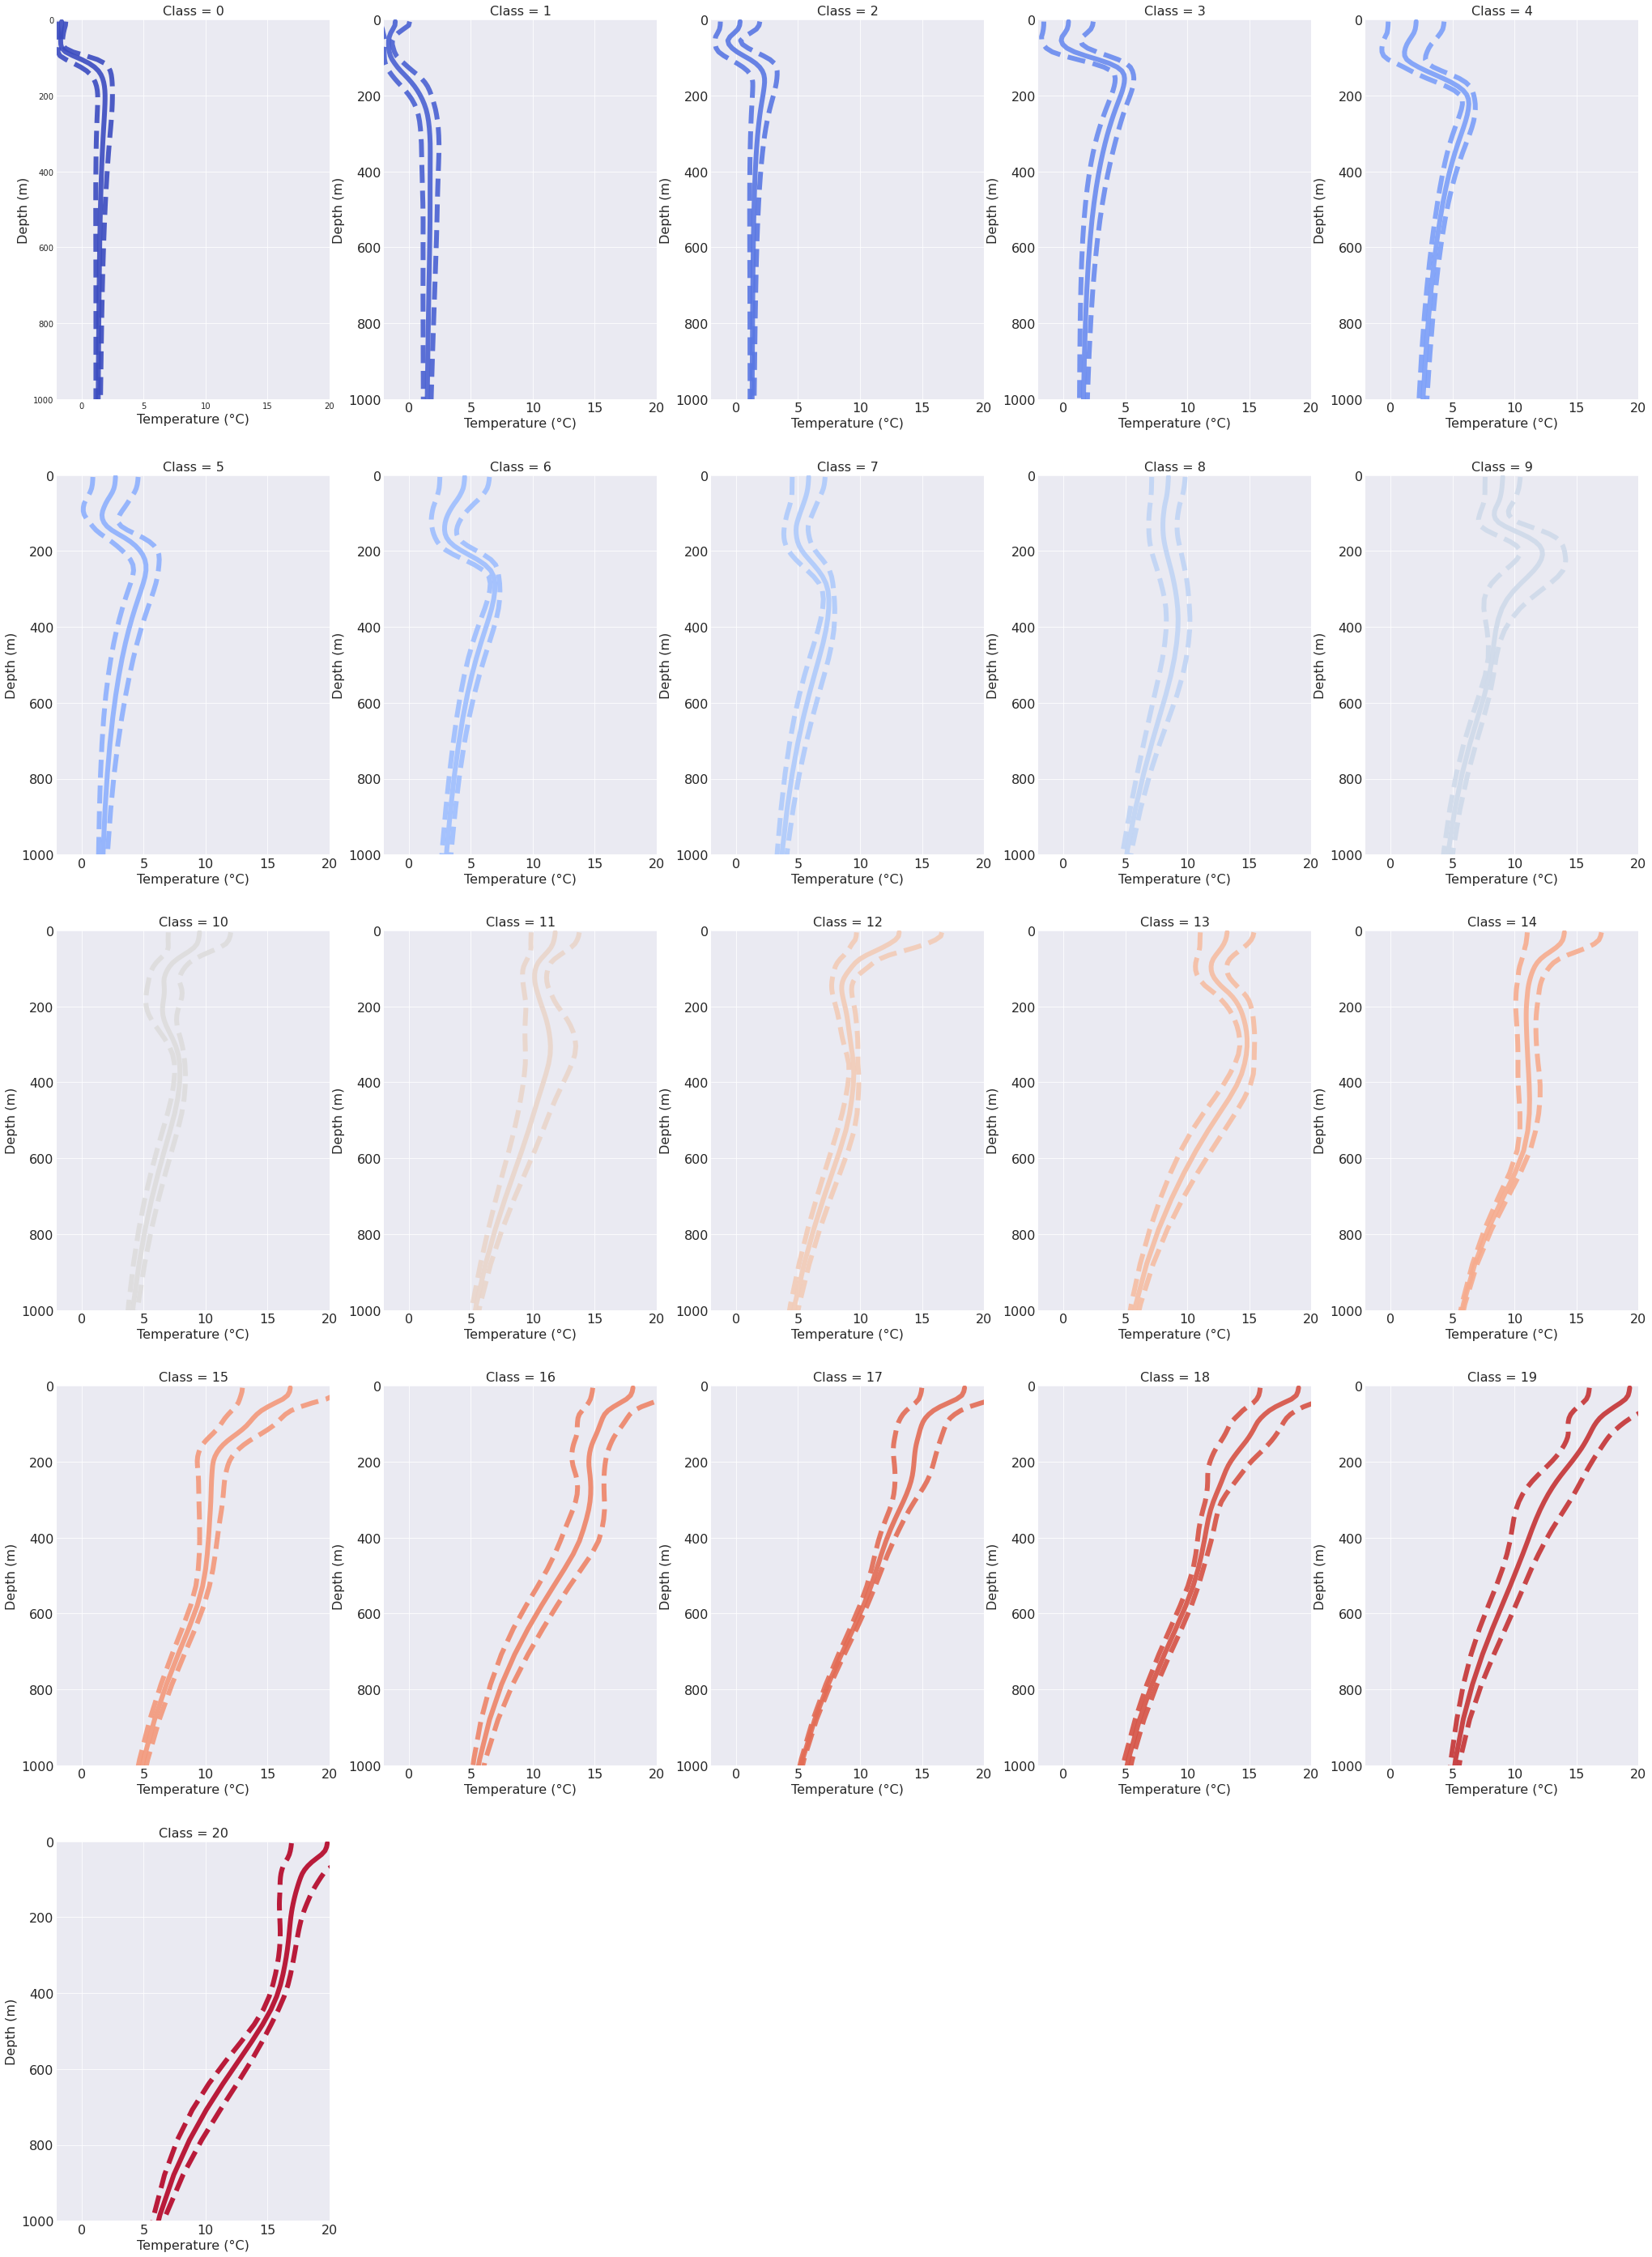

In [17]:
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

<br>

### Plotting location and cluster

In [18]:
sampleLabelData = np.array(sampleDF["labelSorted"])
sampleMetaData = np.append(sampleTimeGeo, [sampleLabelData], axis = 0)
print("Sorted label added to sampleMetaData")

Sorted label added to sampleMetaData


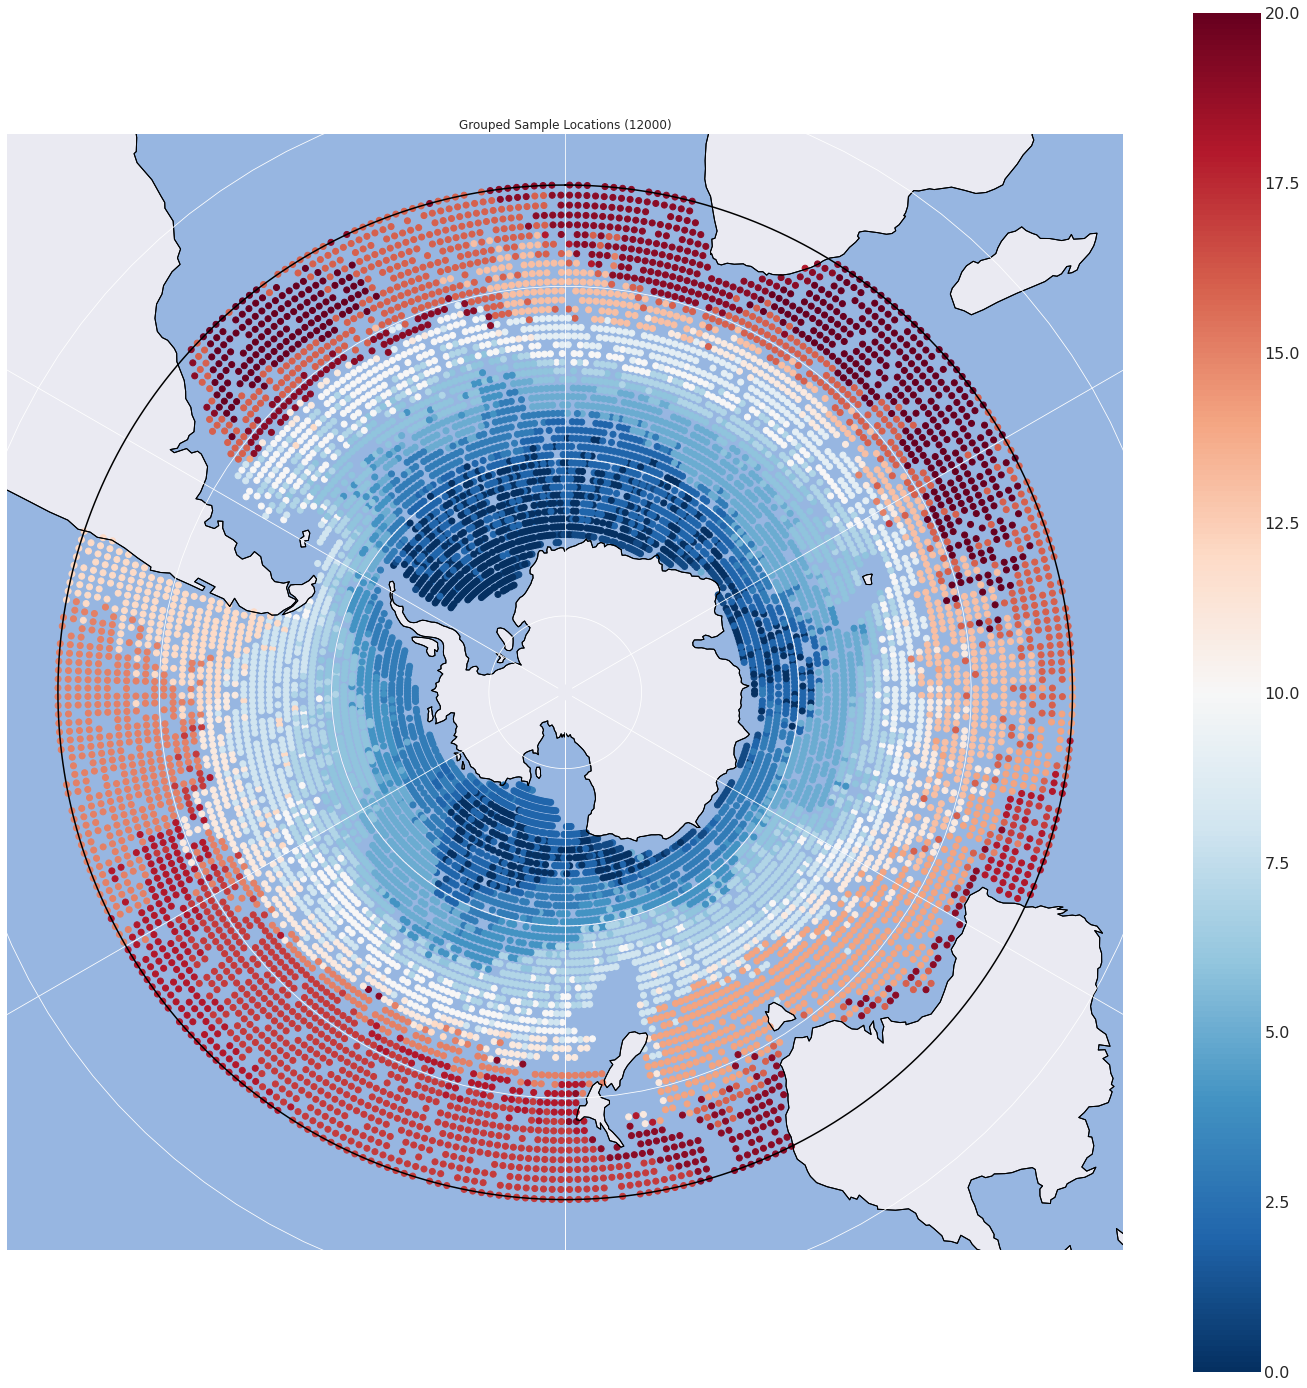

In [19]:
locationPlotGroup(sampleMetaData, (25,25), 1)

Classifications, grouped by month.


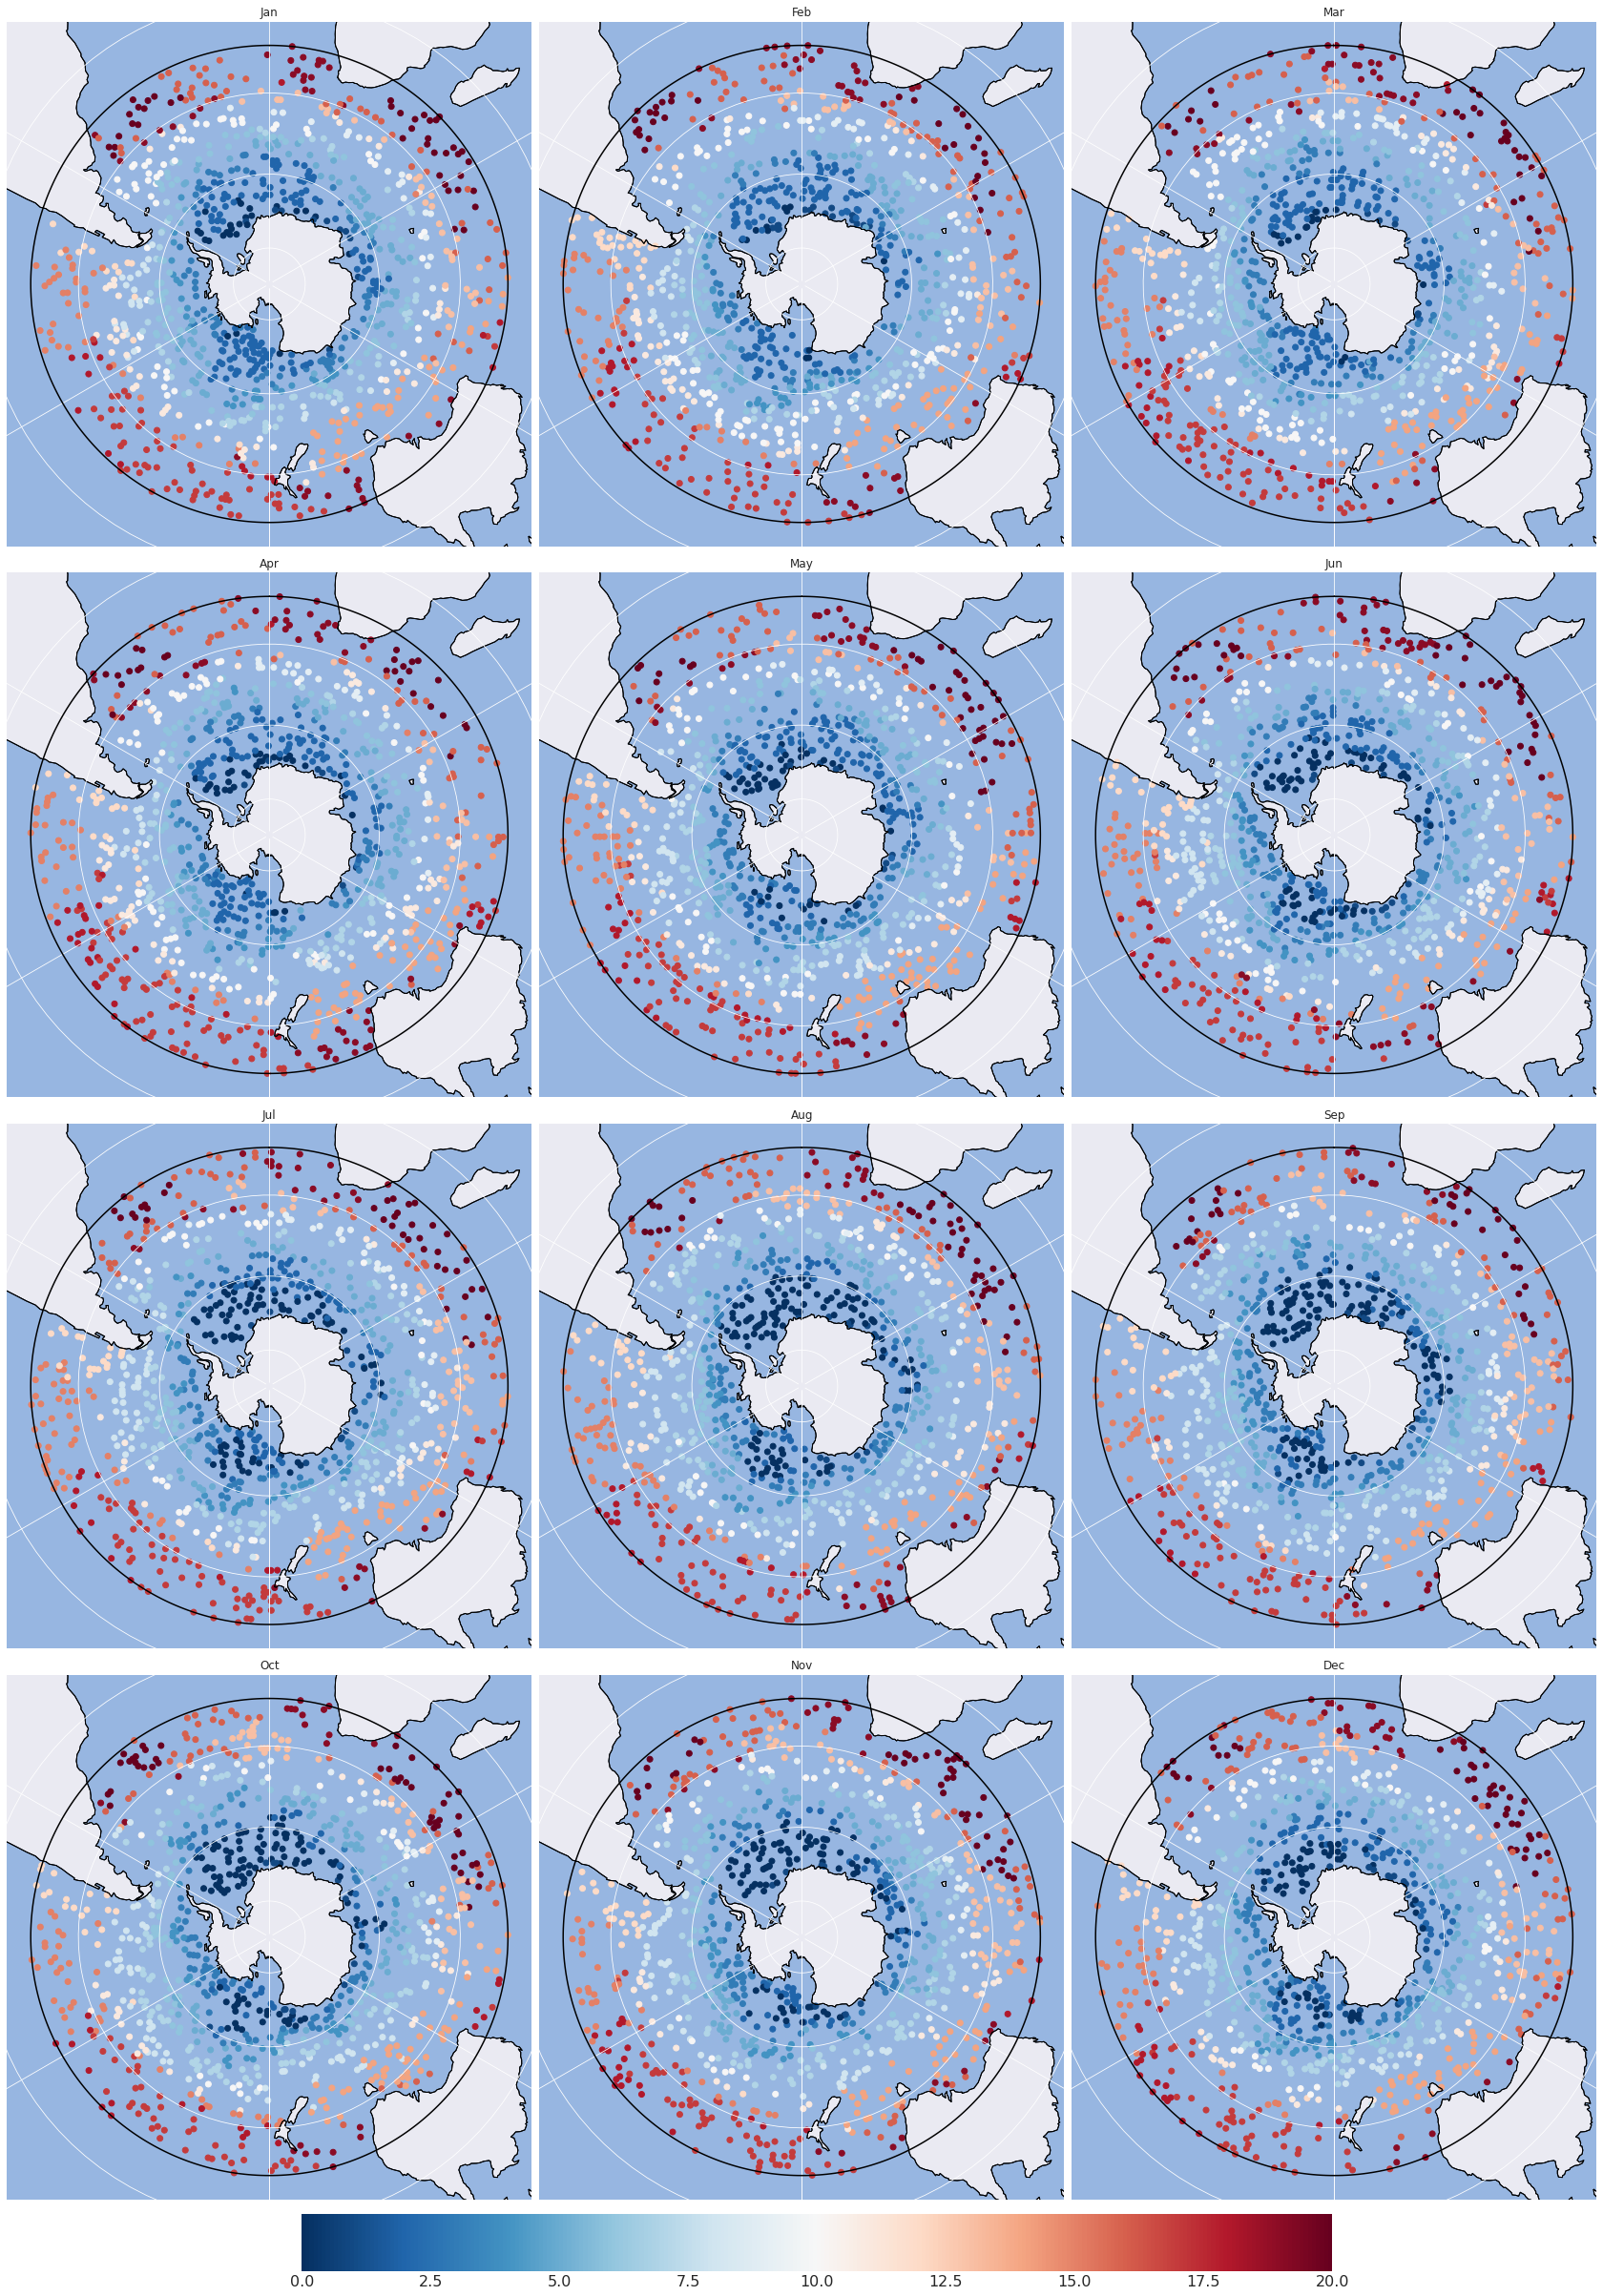

In [20]:
locationPlotGroupDFMonthly(sampleDF, "Monthly summaries for training data set", 1)
print("Classifications, grouped by month.")

Uncertainty in classifications, grouped by month.


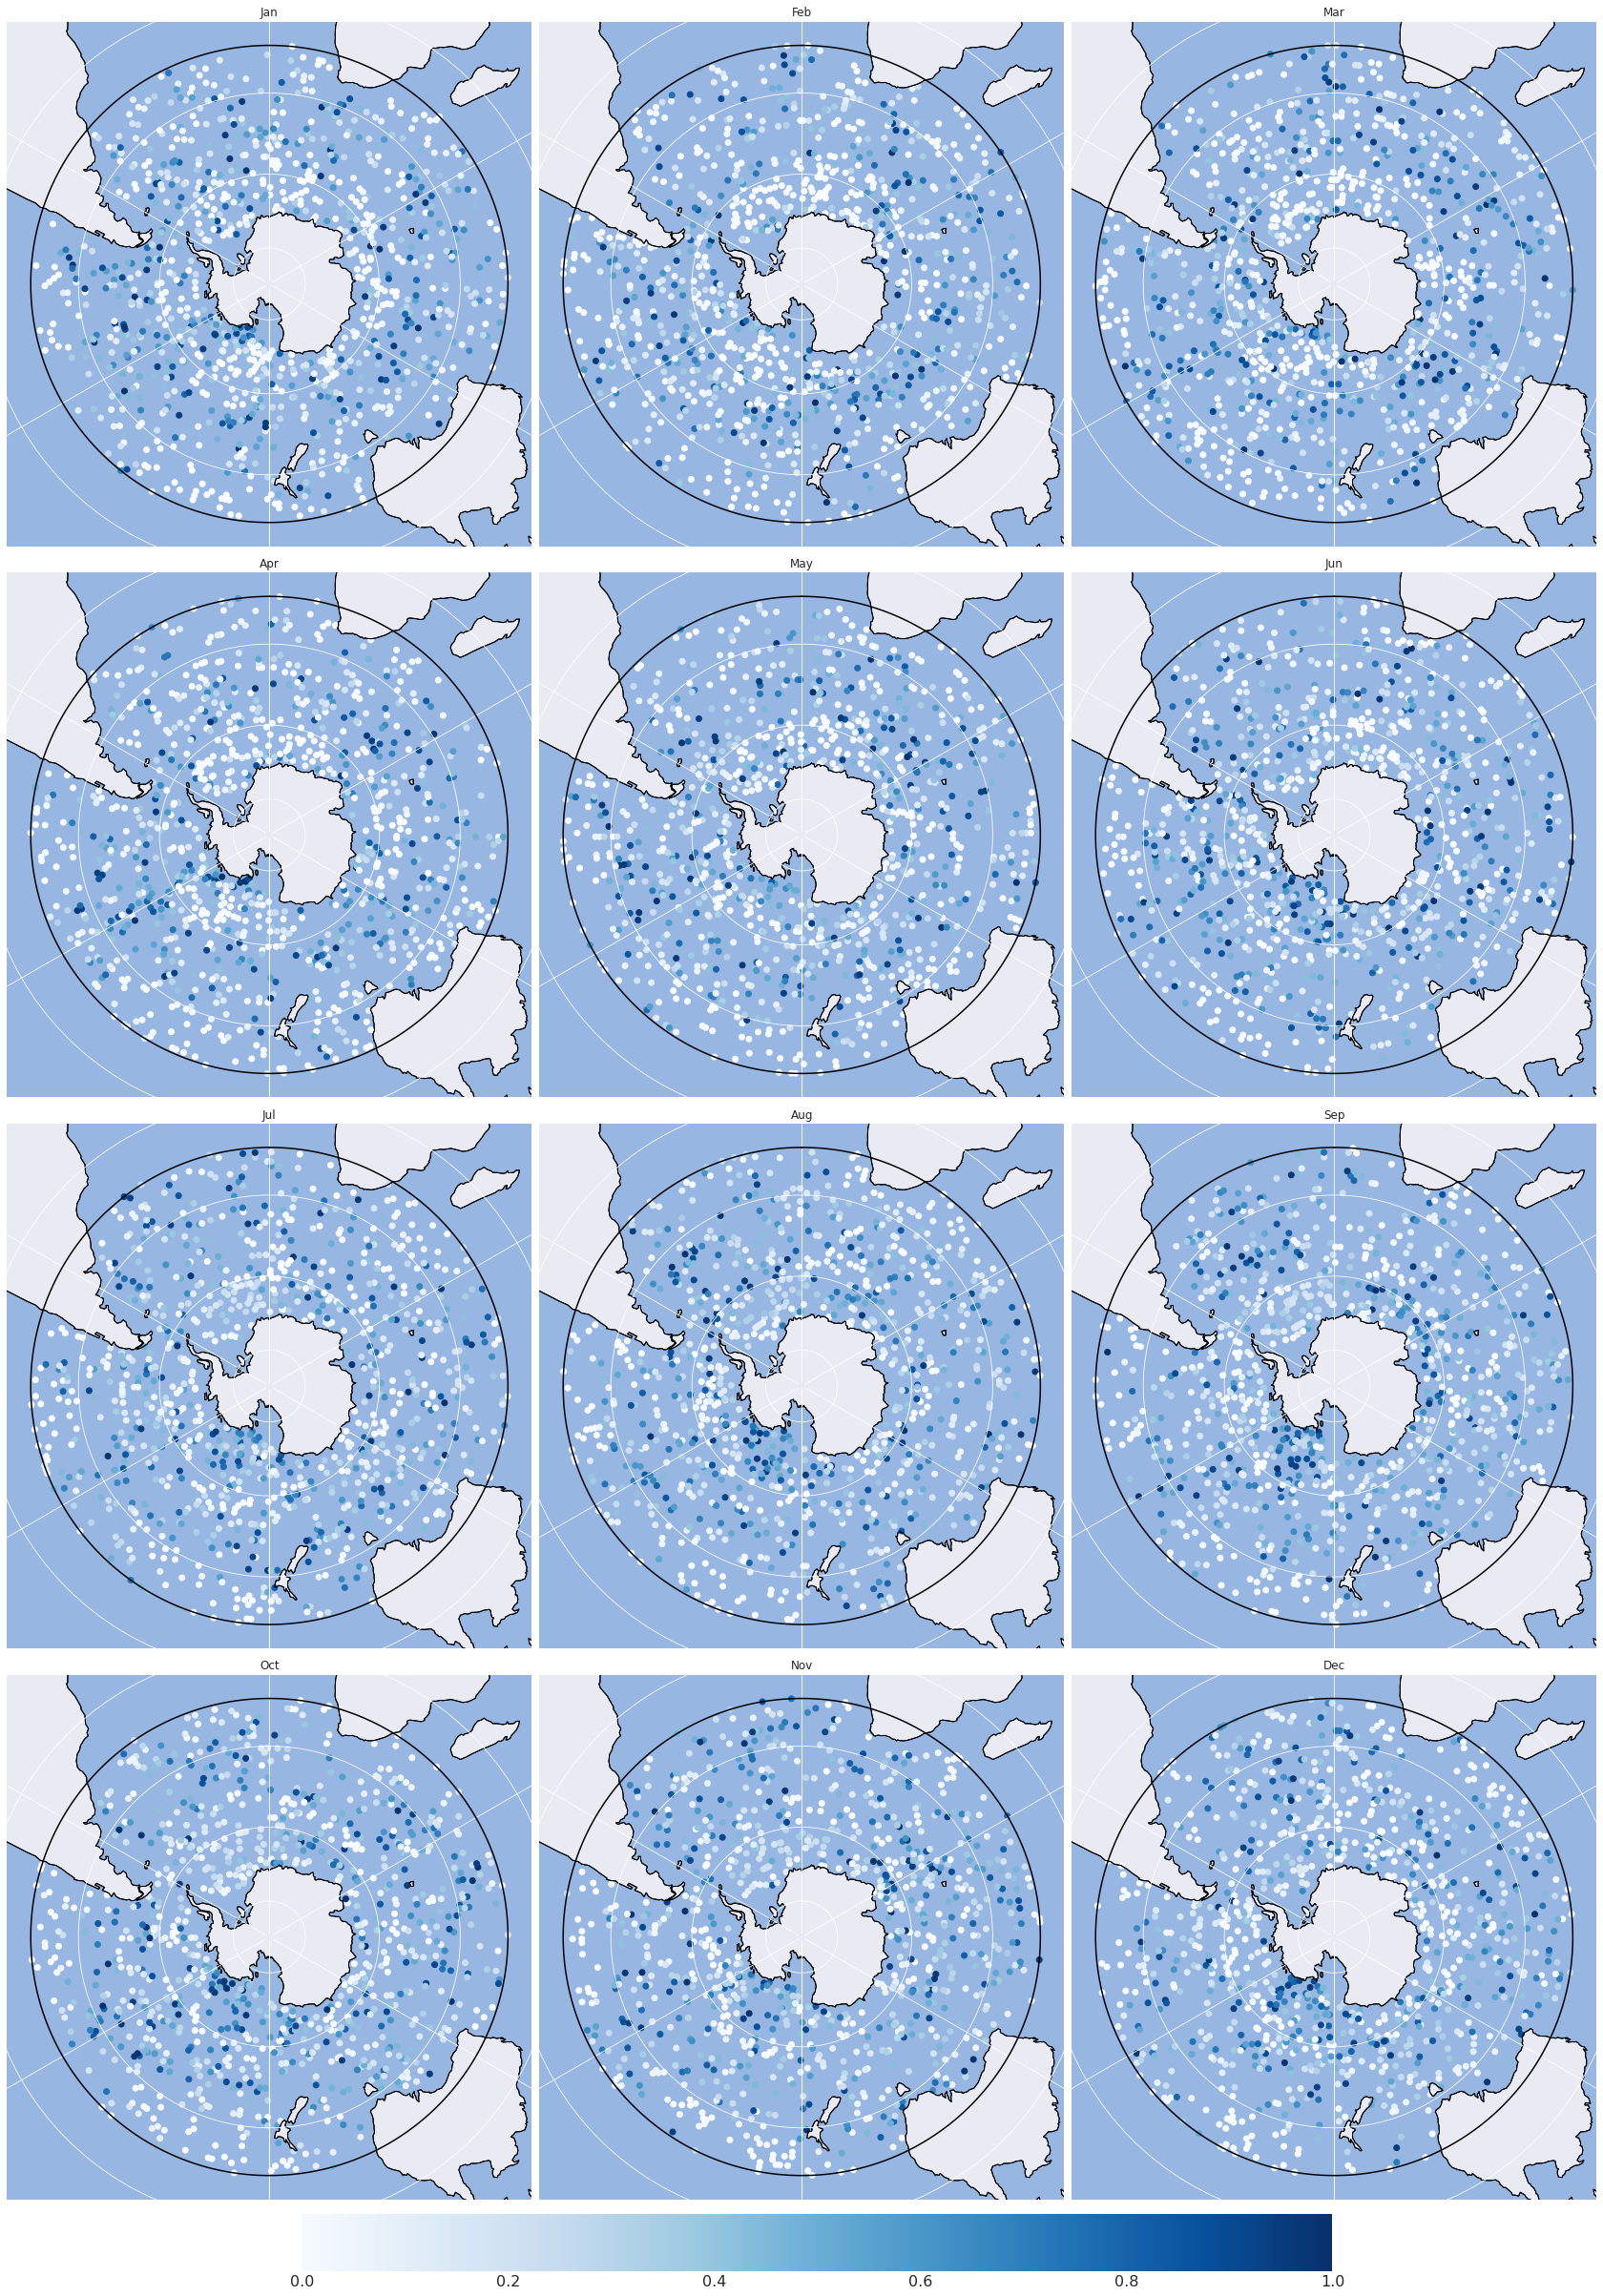

In [21]:
locationPlotUncertaintyDFMonthly(sampleDF, "Monthly uncertainty", 1)
print("Uncertainty in classifications, grouped by month.")